In [1]:
%pip install matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [118]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math

experiment_seconds = 180

In [119]:
commit_pattern = r"commit <block.* height=(\d+)"
latency_pattern = r"Average: (\d+)"


def getAverageStats(experiment_str: str) -> tuple[float, float]:
    logs_path = os.path.join("../experiments", experiment_str)
    log_files = [os.path.join(logs_path, f"log{i}") for i in range(1, 4)]

    log_files_available = 0
    avg_commit, avg_latency = 0, 0
    for log_file in log_files:
        try:
            with open(log_file, "r") as f:
                log_lines = f.readlines()
            
            log_files_available+=1
            last_commit, last_latency = None, None
            for line in reversed(log_lines):
                commit_match = re.search(commit_pattern, line)
                if commit_match and last_commit == None:
                    last_commit = int(commit_match.group(1))
                
                latency_match = re.search(latency_pattern, line)
                if latency_match and last_latency == None:
                    last_latency = int(latency_match.group(1))
                
                if last_commit != None and last_latency != None:
                    break 

            
            if last_commit == None:
                print("No commits done!")
                return (0, 0)
        
            if last_latency == None:
                avg_latency = None
            
            if avg_latency != None:
                avg_latency += last_latency 
                
            avg_commit += last_commit

                
        except FileNotFoundError:
            print(f"Log file {log_file} not found. Skipping.")
    
    avg_commit /= log_files_available
    if avg_latency != None:
        avg_latency /= log_files_available

    avg_commit_per_sec = avg_commit / experiment_seconds

    return avg_commit_per_sec, avg_latency

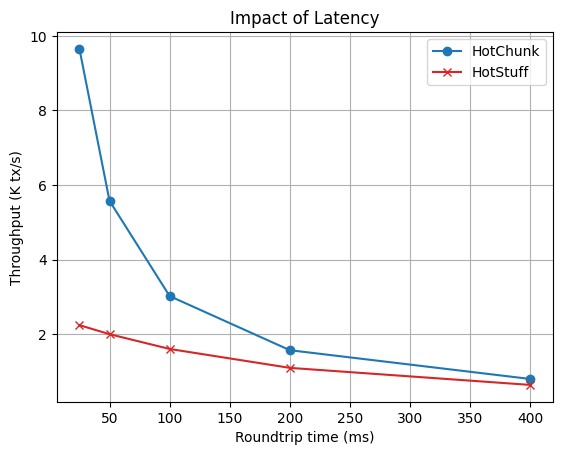

In [120]:
# latency graph
latencies = [25, 50, 100, 200, 400]
branches = ["master", "hotstuff"]

throughput = {"master": [], "hotstuff": []}

for branch in branches:
    for latency in latencies:
        experiment_str = f"['{branch}','{latency}','100','1000','5000']:100:5"
        avg_cps, avg_latency = getAverageStats(experiment_str)
        throughput[branch].append(avg_cps)

plt.plot(latencies, throughput["master"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot(latencies, throughput["hotstuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Roundtrip time (ms)')
plt.ylabel('Throughput (K tx/s)')
plt.title('Impact of Latency')

plt.legend()
plt.grid()


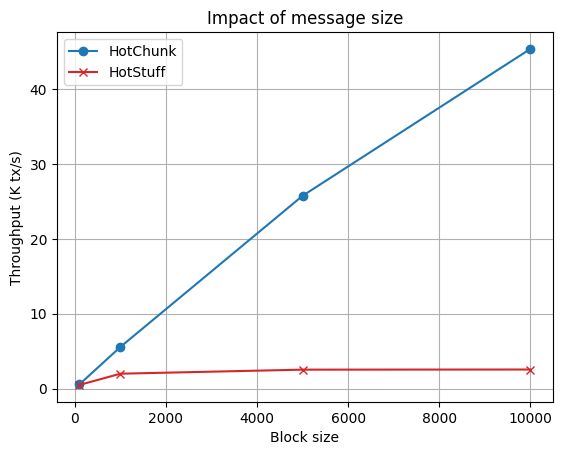

In [121]:
# throughput over message size

block_sizes = [100, 1000, 5000, 10000]
branches = ["master", "hotstuff"]

throughput = {"master": [], "hotstuff": []}

for branch in branches:
    for block_size in block_sizes:
        experiment_str = f"['{branch}','50','100','{block_size}','{5 * block_size}']:100:5"
        avg_cps, avg_latency = getAverageStats(experiment_str)
        throughput[branch].append(avg_cps * block_size / 1000)

plt.plot(block_sizes, throughput["master"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot(block_sizes, throughput["hotstuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Block size')
plt.ylabel('Throughput (K tx/s)')
plt.title('Impact of message size')
#plt.yscale("log")

plt.legend()
plt.grid()

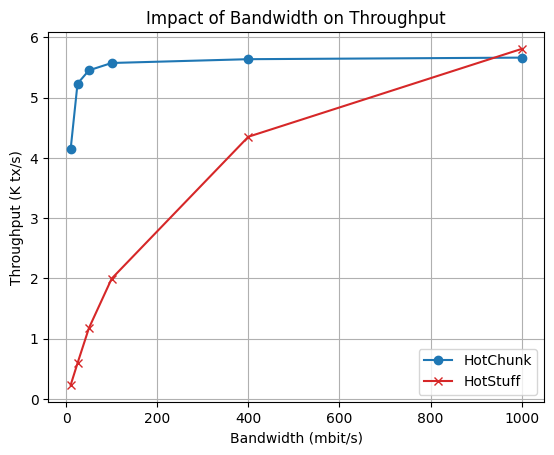

[237.66666666666666, 188.0, 180.66666666666666, 178.0, 175.0, 174.66666666666666]


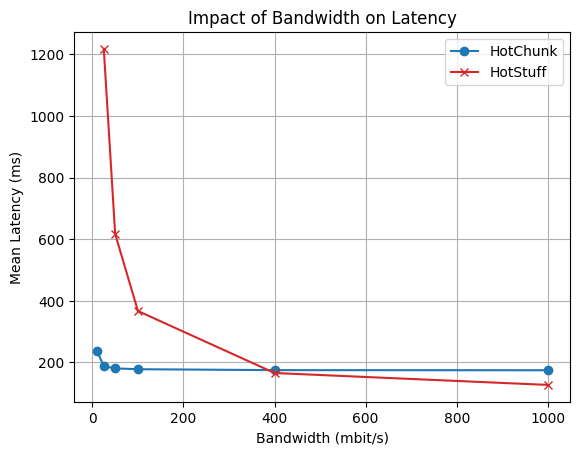

In [127]:
# throughput over bandwidth
bandwidths = [10, 25, 50, 100, 400, 1000]
branches = ["master", "hotstuff"]

throughput = {"master": [], "hotstuff": []}
latency = {"master": [], "hotstuff": []}

for branch in branches:
    for bandwidth in bandwidths:
        experiment_str = f"['{branch}','50','{bandwidth}','1000','5000']:100:5"
        avg_cps, avg_latency = getAverageStats(experiment_str)
        throughput[branch].append(avg_cps)
        latency[branch].append(avg_latency)
plt.plot(bandwidths, throughput["master"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot(bandwidths, throughput["hotstuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Bandwidth (mbit/s)')
plt.ylabel('Throughput (K tx/s)')
plt.title('Impact of Bandwidth on Throughput')
#plt.xscale("log")

plt.legend()
plt.grid()

plt.show()

print(latency["master"])
plt.plot(bandwidths, latency["master"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot(bandwidths, latency["hotstuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Bandwidth (mbit/s)')
plt.ylabel('Mean Latency (ms)')
plt.title('Impact of Bandwidth on Latency')
#plt.xscale("log")

plt.legend()
plt.grid()

plt.show()


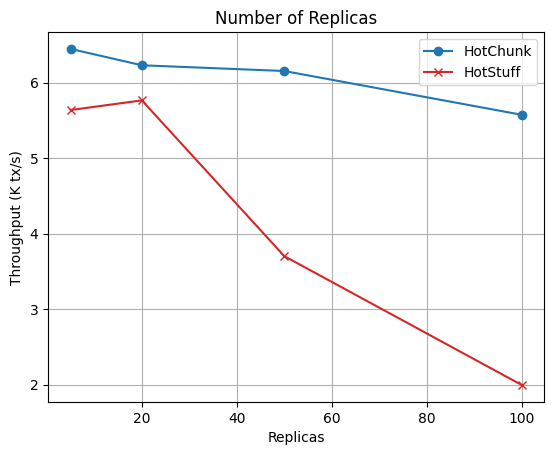

In [123]:
# throughput over nr.of replicas

nr_replicas = [(5,1), (20, 5), (50, 3), (100, 5)]
branches = ["master", "hotstuff"]

throughput = {"master": [], "hotstuff": []}

for branch in branches:
    for replica_count, virtual_machines in nr_replicas:
        experiment_str = f"['{branch}','50','100','1000','5000']:{replica_count}:{virtual_machines}"
        avg_cps, avg_latency = getAverageStats(experiment_str)
        throughput[branch].append(avg_cps)

plt.plot([n for (n, _) in nr_replicas], throughput["master"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot([n for (n, _) in nr_replicas], throughput["hotstuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Replicas')
plt.ylabel('Throughput (K tx/s)')
plt.title('Number of Replicas')

plt.legend()
plt.grid()


[0.065328, 0.09272000000000001, 0.107408, 0.128304, 0.15601600000000002, 0.263472] [0.09627, 0.60971, 1.57241, 3.17691, 6.38591, 16.01291]


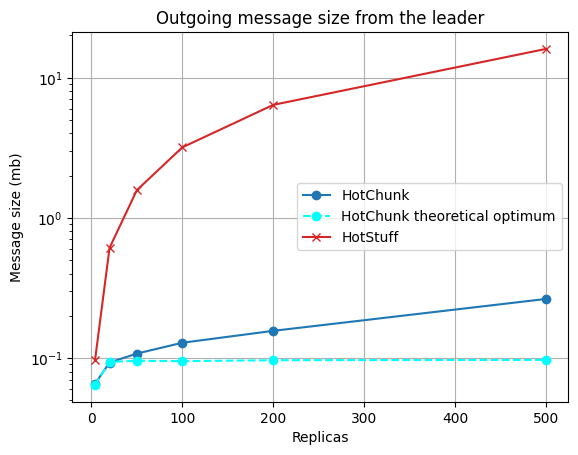

In [126]:
# Proposal size per number of replicas

nr_replicas = [4, 20, 50, 100, 200, 500]

hotStuffSize = 32090

proposalSize = {"HotChunk": [10888, 2440, 1096, 648, 392, 264], "HotStuff": [], "HotChunkTheory": []}


for i, replica in enumerate(nr_replicas):
    proposalSize['HotStuff'].append((replica - 1) * hotStuffSize / 1000_000)
    proposalSize['HotChunk'][i] *= 2 * (replica - 1) / 1000_000

    faulty = int((replica - 1) / 3)
    chunkSize = math.ceil(hotStuffSize / (2*faulty + 1))
    proposalSize['HotChunkTheory'].append(chunkSize * 2 * (replica - 1) / 1000_000)

print(proposalSize["HotChunk"], proposalSize["HotStuff"])

plt.plot(nr_replicas, proposalSize["HotChunk"], marker='o', linestyle='-', color='tab:blue', label='HotChunk')
plt.plot(nr_replicas, proposalSize["HotChunkTheory"], marker='o', linestyle='--', color='cyan', label='HotChunk theoretical optimum')
plt.plot(nr_replicas, proposalSize["HotStuff"], marker='x', linestyle='-', color='tab:red', label='HotStuff')

plt.xlabel('Replicas')
plt.ylabel('Message size (mb)')
plt.title('Outgoing message size from the leader')
plt.yscale("log")

plt.legend()
plt.grid()

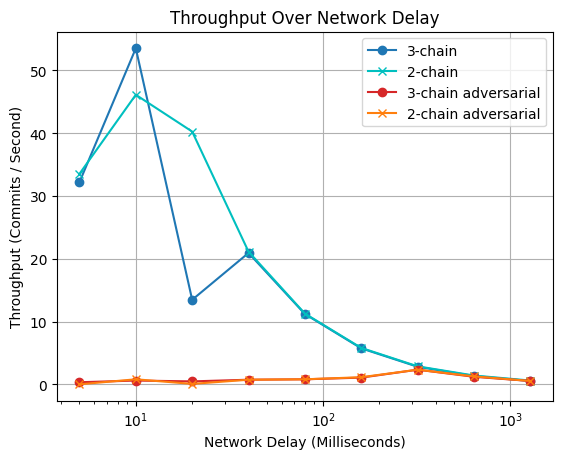

In [100]:
# Throughput Over Network Delay

delay = [1280, 640, 320, 160, 80, 40, 20, 10, 5]

thr_3 = [0.533, 1.333, 2.8, 5.733, 11.2, 20.933, 13.467, 53.533, 32.2]
thr_2 = [0.6, 1.4, 2.867, 5.8, 11.267, 21.133, 40.267, 46.133, 33.533]
thr_adv_3 = [0.533, 1.2, 2.33, 1.067, 0.8, 0.733, 0.467, 0.6, 0.33]
thr_adv_2 = [0.533, 1.266, 2.33, 1.133, 0.8, 0.733, 0.067, 0.8, 0]

lat_3 = [23.5, 22.8, 19, 24.4, 314.65, 440.78, 451.4]

# Create the plot
plt.plot(delay, thr_3, marker='o', linestyle='-', color='tab:blue', label='3-chain')
plt.plot(delay, thr_2, marker='x', linestyle='-', color='c', label='2-chain')
plt.plot(delay, thr_adv_3, marker='o', linestyle='-', color='tab:red', label='3-chain adversarial')
plt.plot(delay, thr_adv_2, marker='x', linestyle='-', color='tab:orange', label='2-chain adversarial')

# Add labels and title
plt.xlabel('Network Delay (Milliseconds)')
plt.ylabel('Throughput (Commits / Second)')
plt.title('Throughput Over Network Delay')
plt.xscale('log')

# Add a legend
plt.legend()

# Display the graph
plt.grid(True)
plt.show()

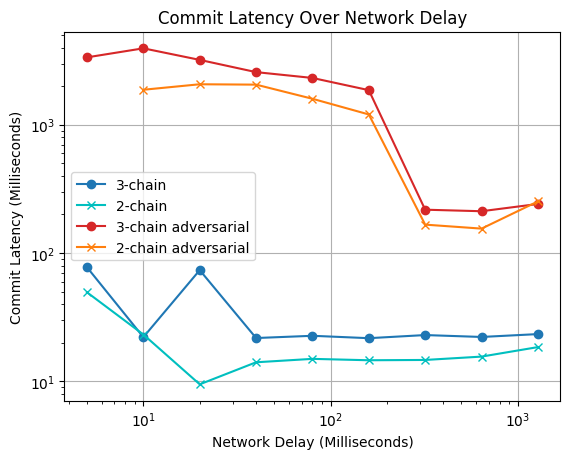

In [73]:
# Commit Latency Over Network Delay

# delay = [500, 200, 100, 50, 20, 10, 0]
delay = [1280, 640, 320, 160, 80, 40, 20, 10, 5]

lat_3 = [23.34, 22.17, 22.94, 21.69, 22.64, 21.75, 73.62, 22.09, 77.5]
lat_2 = [18.48, 15.58, 14.67, 14.59, 14.96, 14.07, 9.47, 23.17, 49.44]
lat_adv_3 = [241.56, 212.05, 217.98, 1866, 2323, 2579, 3213, 3955, 3363]
delay_adv_2 = [1280, 640, 320, 160, 80, 40, 20, 10]
lat_adv_2 = [252.9, 155.19, 166.7, 1206, 1598, 2060, 2074, 1879]

# Create the plot
plt.plot(delay, lat_3, marker='o', linestyle='-', color='tab:blue', label='3-chain')
plt.plot(delay, lat_2, marker='x', linestyle='-', color='c', label='2-chain')
plt.plot(delay, lat_adv_3, marker='o', linestyle='-', color='tab:red', label='3-chain adversarial')
plt.plot(delay[:-1], lat_adv_2, marker='x', linestyle='-', color='tab:orange', label='2-chain adversarial')

plt.xlabel('Network Delay (Milliseconds)')
plt.ylabel('Commit Latency (Milliseconds)')
plt.title('Commit Latency Over Network Delay')

plt.yscale('log')
plt.xscale('log')

plt.legend()

plt.grid(True)
plt.show()

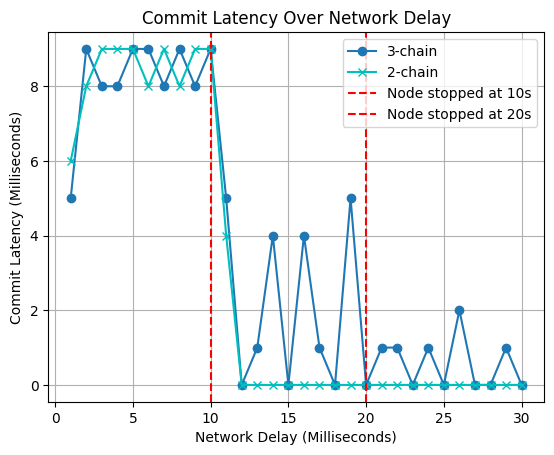

In [76]:
# Commit Latency Over Network Delay

time = [i for i in range(1,31)]

commits_3 = [5, 9, 8, 8, 9, 9, 8, 9, 8, 9, 5, 0, 1, 4, 0, 4, 1, 0, 5, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0]
commits_2 = [6, 8, 9, 9, 9, 8, 9, 8, 9, 9, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(time, commits_3, marker='o', linestyle='-', color='tab:blue', label='3-chain')
plt.plot(time, commits_2, marker='x', linestyle='-', color='c', label='2-chain')
plt.axvline(x=10, color='r', linestyle='--', label='Node stopped at 10s')
plt.axvline(x=20, color='r', linestyle='--', label='Node stopped at 20s')
plt.xlabel('Network Delay (Milliseconds)')
plt.ylabel('Commit Latency (Milliseconds)')
plt.title('Commit Latency Over Network Delay')

plt.legend()

plt.grid(True)
plt.show()

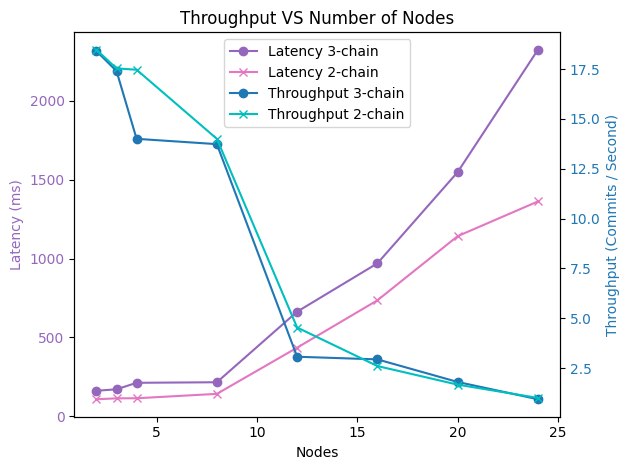

In [86]:
nodes = [2, 3, 4, 8, 12, 16, 20, 24]

latency_3 = [
    161.128801,
    170.348698,
    211.568052,
    215.09343,
    662.744983,
    969.268471,
    1548.11442,
    2324.033699
]
# latency_3 = [i/15 for i in latency_3]
commits_3 = [276, 261, 210, 206, 46, 44, 27, 14]
commits_3 = [i / 15 for i in commits_3]

latency_2 = [
    107.226335,
    112.974461,
    113.571492,
    141.35449,
    434.548813,
    734.802599,
    1141.864117,
    1361.984554
]
commits_2 = [277, 263, 262, 210, 68, 39, 25, 15]
commits_2 = [i / 15 for i in commits_2]

fig, ax1 = plt.subplots()

color = 'tab:purple'
color_2 = 'tab:pink'
ax1.set_xlabel('Nodes')
ax1.set_ylabel('Latency (ms)', color=color)
line1, = ax1.plot(nodes, latency_3, color=color, marker='o', label='Latency 3-chain')
ax1.tick_params(axis='y', labelcolor=color)
line2, = ax1.plot(nodes, latency_2, color=color_2, marker='x', label='Latency 2-chain')


ax2 = ax1.twinx()
color = 'tab:blue'
color_2 = 'c'
ax2.set_ylabel('Throughput (Commits / Second)', color=color)
line3, = ax2.plot(nodes, commits_3, color=color, marker='o', label='Throughput 3-chain')
line4, = ax2.plot(nodes, commits_2, color=color_2, marker='x', label='Throughput 2-chain')

ax2.tick_params(axis='y', labelcolor=color)

# 从两个轴中分别获取图例句柄和标签
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 将两个轴的图例信息合并
all_lines = lines1 + lines2
all_labels = labels1 + labels2

# 最终一次性创建合并后的图例
ax1.legend(all_lines, all_labels, loc='upper center')

plt.title('Throughput VS Number of Nodes')
plt.tight_layout()